# Resting EEG Data

This notebook analyzes a dataset of EEG data collected from healthy young adults.

## Dataset Details

This dataset is a dataset of extra-cranial EEG data recorded in the Voytek Lab. 

Analyzed data is taken from eyes-closed resting state data collected prior to a visual-detection psychophysics task.

In [1]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import mne
from mne.viz import plot_topomap

from fooof import FOOOF
from fooof.utils import trim_spectrum

from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_75721/2881316490.py:11: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB, get_files, load_eeg_demo_data
from apm.run import run_measures, run_group_measures
from apm.analysis import (compute_avgs, compute_all_corrs, compute_corrs_to_feature,
                          compute_diffs_to_feature, unpack_corrs)
from apm.plts import plot_dots, plot_corr_matrix
from apm.plts.multi import plot_results_all
from apm.plts.utils import make_axes
from apm.plts.settings import EXT
from apm.methods import (autocorr_decay_time, hurst, dfa, higuchi_fd, hjorth_complexity,
                         lempelziv, app_entropy, perm_entropy, specparam, irasa)
from apm.methods.settings import (AC_DECAY_PARAMS, HURST_PARAMS, DFA_PARAMS, HFD_PARAMS,
                                  HJC_PARAMS, LZ_PARAMS, AP_ENT_PARAMS, PE_ENT_PARAMS)
from apm.methods.periodic import alpha_power
from apm.utils import format_corr

In [3]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Define the data folder
folder = '/Users/tom/Data/VoytekLab/ExtractedSubsets/eeg_data'

In [5]:
# Define data field to extract from files
data_field = 'oz_rest_data'

In [6]:
# Define data information
fs = 500
n_seconds = 120

In [7]:
# Define times vector for data
times = create_times(n_seconds, fs)

In [8]:
# Add plot kwargs
dot_kwargs = {
    'alpha' : 0.75,
}

In [9]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = APMDB().figs_path / '51_eeg_data'

## Load Data


In [10]:
# Get the list of available files
files = get_files(folder, select='.mat')

In [11]:
# FIX: temporarily drop subject which has a data quirk (wrong size array)
files.remove('1009.mat')

In [12]:
# Check the number of subjects
n_subjs = len(files)
print('Number of subjects: {}'.format(n_subjs))

Number of subjects: 28


In [13]:
# Load data
data = load_eeg_demo_data(files, folder, data_field)

## Data Checks

In [14]:
# Set example data index
data_ind = 12

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


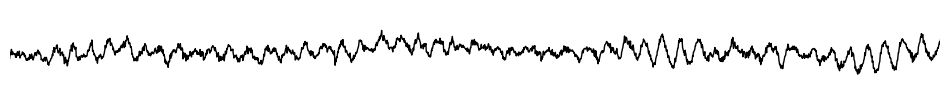

In [15]:
# Plot a segment of time series data
plot_time_series(times, data[data_ind, :], lw=1., xlim=[5, 10], figsize=(12, 1))
plt.gca().axis('off');
if SAVE_FIG: plt.savefig(FIGPATH / ('eeg_timeseries' + EXT))

In [16]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(data[data_ind, :], fs, nperseg=2*fs, noverlap=fs)

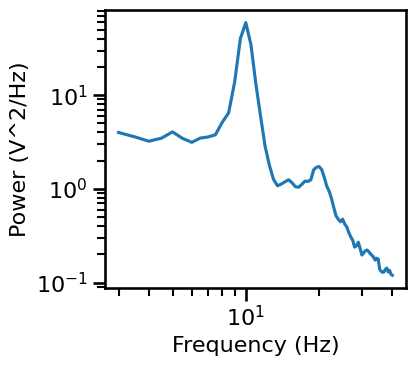

In [17]:
# Plot the power spectrum of the example data segment
plot_power_spectra(*trim_spectrum(freqs, powers, [3, 40]), figsize=(4.5, 4), 
                   save_fig=SAVE_FIG, file_name='rest_eeg_psd' + EXT, file_path=FIGPATH)

## Compute Measures

### Aperiodic Methods

In [18]:
# General method settings
f_range = [3, 40]
specparam_kwargs = {'min_peak_height' : 0.05, 'fs' : fs, 'f_range' : f_range}
irasa_kwargs = {'fs' : fs, 'f_range' : f_range}

In [19]:
# # Initialize specparam model
# fm = FOOOF(verbose=False)

In [20]:
# Define measures to apply, along with input parameters
measures = {
    autocorr_decay_time : AC_DECAY_PARAMS,
    hurst : HURST_PARAMS,
    dfa : DFA_PARAMS,
    higuchi_fd : HFD_PARAMS,
    hjorth_complexity : HJC_PARAMS,
    lempelziv : LZ_PARAMS,
    app_entropy : AP_ENT_PARAMS,
    perm_entropy : PE_ENT_PARAMS,
    specparam : specparam_kwargs,
    irasa : irasa_kwargs,
}

In [21]:
# Compute measures of interest on the data
results = run_measures(data, measures)

In [22]:
# Compute correlations across all pairs of methods
all_corrs = compute_all_corrs(results)

In [23]:
# Collect list of exponent & timeseries measure labels
exp_measures = ['specparam', 'irasa']
ts_measures = list(results.keys())
[ts_measures.remove(meas) for meas in exp_measures];

### Peak Measures

In [24]:
# Define periodic measures to compute
peak_measures = {alpha_power : measures[specparam]}

# Compute periodic measures
peak_results = run_measures(data, peak_measures)

### Compare Exponent Measures

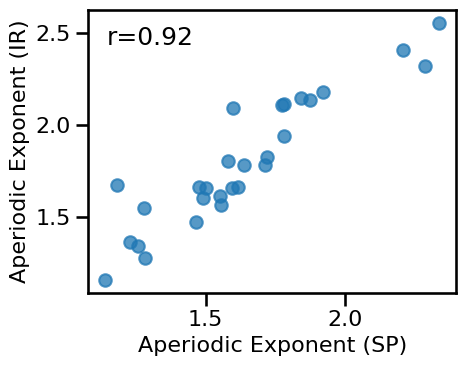

In [25]:
# Plot the comparison of specparam and IRASA exponent estimations
plot_dots(results['specparam'], results['irasa'], **dot_kwargs, figsize=(5, 4),
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)', tposition='tl',
          save_fig=SAVE_FIG, file_name='eeg_exp_exp_comp' + EXT, file_path=FIGPATH)

In [26]:
# Check correlation between specparam and irasa exponent estimates
print('  SP-EXP & IR-EXP:  ', format_corr(*all_corrs['specparam']['irasa']))

  SP-EXP & IR-EXP:   r=+0.920  CI[+0.767, +0.980],  p=0.000


### Compare Exponent to TS Measures

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anacond

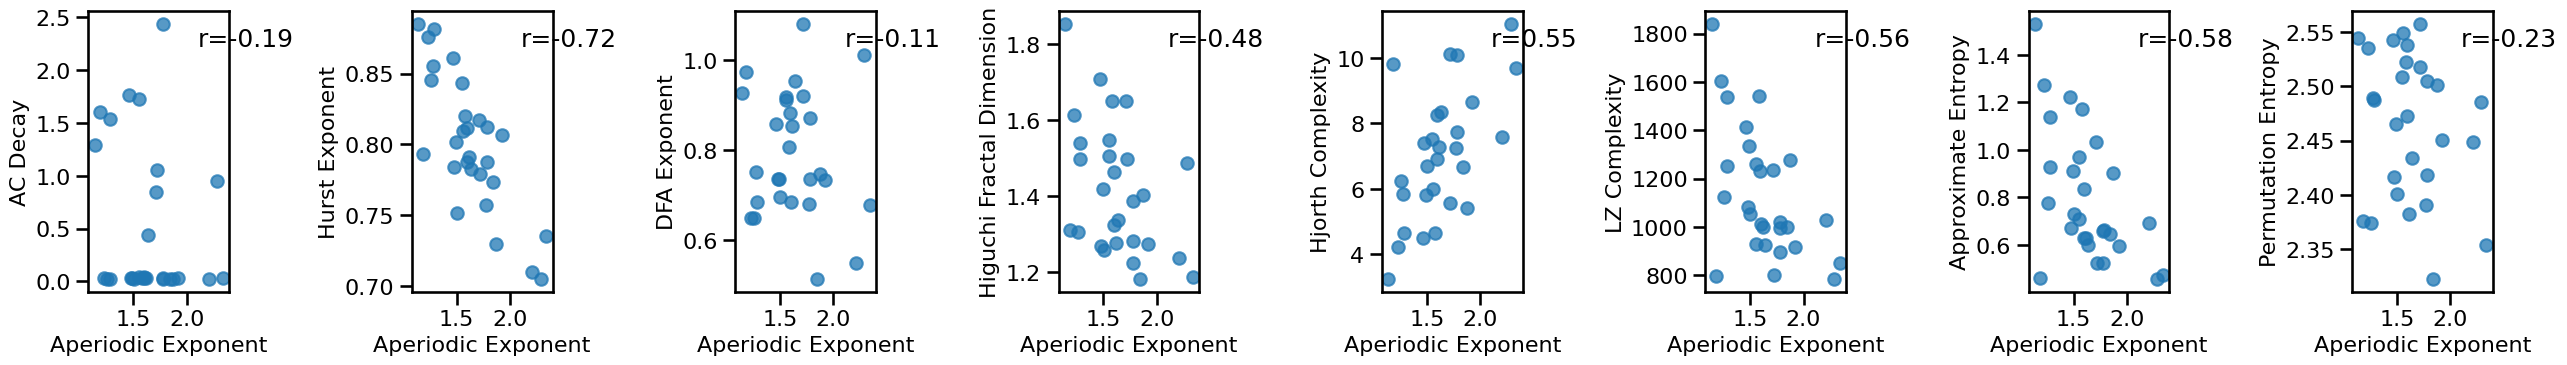

In [59]:
axes = make_axes(1, len(ts_measures), figsize=(26, 4), wspace=0.1)
plot_dots(results['specparam'], results['autocorr_decay_time'], **dot_kwargs,
         xlabel='Aperiodic Exponent', ylabel='AC Decay', ax=axes[0])
plot_dots(results['specparam'], results['hurst'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Hurst Exponent', ax=axes[1])
plot_dots(results['specparam'], results['dfa'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='DFA Exponent', ax=axes[2])
plot_dots(results['specparam'], results['higuchi_fd'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Higuchi Fractal Dimension', ax=axes[3])
plot_dots(results['specparam'], results['hjorth_complexity'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Hjorth Complexity', ax=axes[4])
plot_dots(results['specparam'], results['lempelziv'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='LZ Complexity', ax=axes[5])
plot_dots(results['specparam'], results['app_entropy'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Approximate Entropy', ax=axes[6])
plot_dots(results['specparam'], results['perm_entropy'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Permutation Entropy', ax=axes[7])
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_ts_scatters' + EXT))

In [28]:
# Check the correlations between time series and exponent measures
print('  SP-EXP & Hurst:  ', format_corr(*all_corrs['specparam']['hurst']))
print('  IR-EXP & Hurst:  ', format_corr(*all_corrs['irasa']['hurst']))
print('  SP-EXP & DFA:    ', format_corr(*all_corrs['specparam']['dfa']))
print('  IR-EXP & DFA:    ', format_corr(*all_corrs['irasa']['dfa']))
print('  SP-EXP & LZC:    ', format_corr(*all_corrs['specparam']['lempelziv']))
print('  IR-EXP & LZC:    ', format_corr(*all_corrs['irasa']['lempelziv']))
print('  SP-EXP & HJC:    ', format_corr(*all_corrs['specparam']['hjorth_complexity']))
print('  IR-EXP & HJC:    ', format_corr(*all_corrs['irasa']['hjorth_complexity']))
print('  SP-EXP & ENT:    ', format_corr(*all_corrs['specparam']['app_entropy']))
print('  IR-EXP & ENT:    ', format_corr(*all_corrs['irasa']['app_entropy']))

  SP-EXP & Hurst:   r=-0.720  CI[-0.895, -0.429],  p=0.000
  IR-EXP & Hurst:   r=-0.758  CI[-0.911, -0.474],  p=0.000
  SP-EXP & DFA:     r=-0.112  CI[-0.516, +0.348],  p=0.570
  IR-EXP & DFA:     r=-0.137  CI[-0.549, +0.328],  p=0.486
  SP-EXP & LZC:     r=-0.561  CI[-0.840, -0.160],  p=0.002
  IR-EXP & LZC:     r=-0.649  CI[-0.853, -0.330],  p=0.000
  SP-EXP & HJC:     r=+0.552  CI[+0.168, +0.831],  p=0.002
  IR-EXP & HJC:     r=+0.649  CI[+0.326, +0.840],  p=0.000
  SP-EXP & ENT:     r=-0.577  CI[-0.848, -0.176],  p=0.001
  IR-EXP & ENT:     r=-0.691  CI[-0.858, -0.417],  p=0.000


### Compare Time Series Measures to Each Other

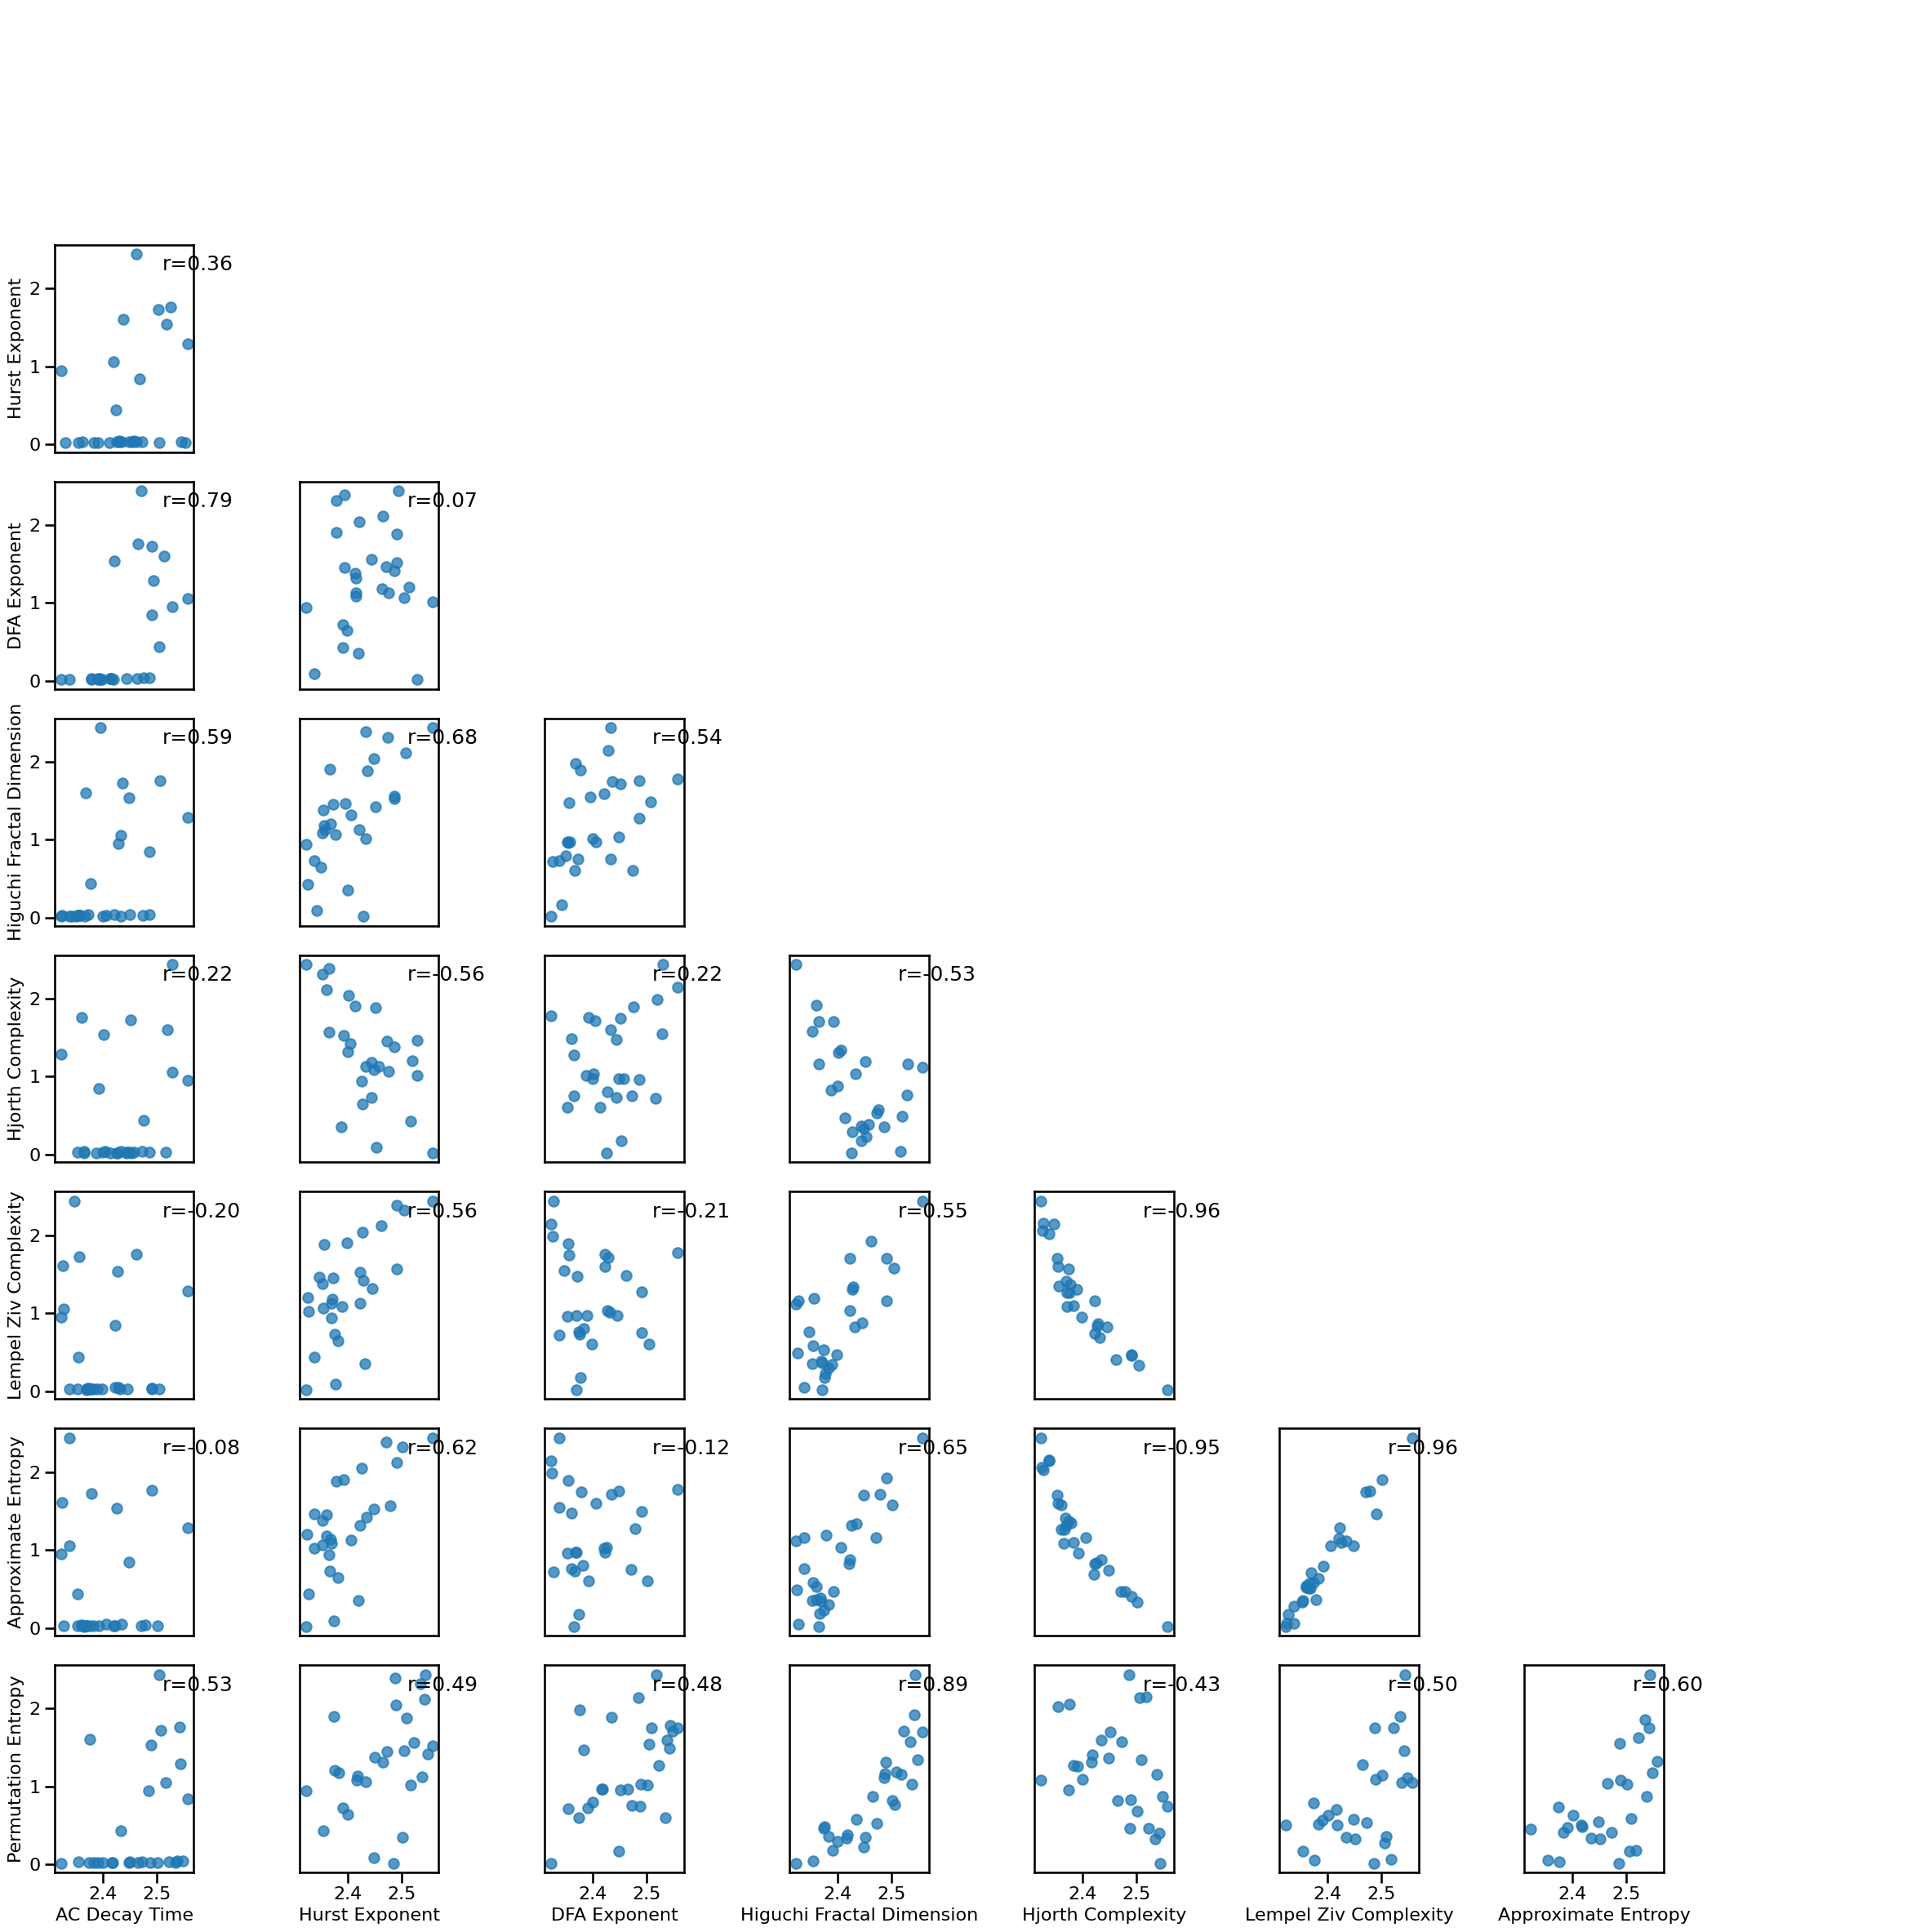

In [29]:
# Plot multi-panel plot comparing all time series measures to each other
plot_results_all(results, ts_measures)

In [30]:
all_corrs_ts = deepcopy(all_corrs)
[all_corrs_ts.pop(meas) for meas in exp_measures];

In [31]:
all_corrs_mat = unpack_corrs(all_corrs_ts)

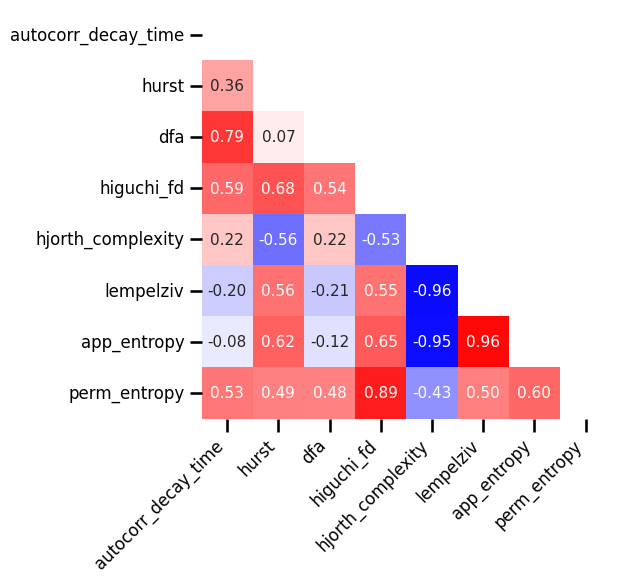

In [63]:
plot_corr_matrix(all_corrs_mat, xticklabels=ts_measures, yticklabels=ts_measures,
                 cbar=False, figsize=(6, 6))
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, fontsize=12, ha='right');
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0, fontsize=12);
if SAVE_FIG: plt.savefig(FIGPATH / ('ts_corr_mat_subjs' + EXT))

In [33]:
exp_corrs_subjs = deepcopy(all_corrs['specparam'])
exp_corrs_subjs.pop('irasa');
exp_corrs_subjs = np.atleast_2d([exp_corrs_subjs[label][0] for label in ts_measures]).T

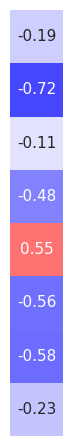

In [34]:
plot_corr_matrix(exp_corrs_subjs, xticks=[], yticks=[], cbar=False,
                 save_fig=SAVE_FIG, file_name='exp_corr_subjs' + EXT, file_path=FIGPATH)

### Compare to Alpha Power

In [35]:
# Compute correlations between aperiodic measures and alpha power
alpha_corrs = compute_corrs_to_feature(results, peak_results['alpha_power'])

In [36]:
# Compute differences between correlations between aperiodic measures and alpha power
alpha_corr_diffs = compute_diffs_to_feature(results, peak_results['alpha_power'])

In [37]:
# Check the correlations between alpha power and aperiodic measures
print('Correlations with alpha:')
for label in alpha_corrs.keys():
    print('     {:20s}:  '.format(label), format_corr(*alpha_corrs[label]))

Correlations with alpha:
     autocorr_decay_time :   r=-0.812  CI[-0.898, -0.648],  p=0.000
     hurst               :   r=-0.331  CI[-0.679, +0.103],  p=0.086
     dfa                 :   r=-0.853  CI[-0.930, -0.705],  p=0.000
     higuchi_fd          :   r=-0.662  CI[-0.849, -0.332],  p=0.000
     hjorth_complexity   :   r=-0.039  CI[-0.470, +0.392],  p=0.842
     lempelziv           :   r=+0.069  CI[-0.338, +0.486],  p=0.727
     app_entropy         :   r=-0.025  CI[-0.441, +0.405],  p=0.901
     perm_entropy        :   r=-0.574  CI[-0.797, -0.251],  p=0.001
     specparam           :   r=+0.159  CI[-0.270, +0.552],  p=0.418
     irasa               :   r=+0.218  CI[-0.213, +0.602],  p=0.265


In [38]:
alpha_corrs_ts = np.atleast_2d([alpha_corrs[label][0] for label in ts_measures]).T

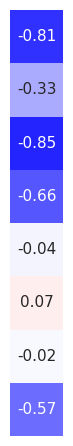

In [39]:
plot_corr_matrix(alpha_corrs_ts, xticks=[], yticks=[], cbar=False,
                 save_fig=SAVE_FIG, file_name='alpha_corr_subjs' + EXT, file_path=FIGPATH)

## Topographies

In [40]:
path = Path('/Users/tom/Desktop/apm_data/')

In [41]:
data1 = np.load(path / 'rtPB_extracted_block.npy')
data2 = np.load(path / 'PBA_extracted_block.npy')
group_data = np.vstack([data1, data2])

In [42]:
FS = 500

#### Set up montage information

In [43]:
with open(path / 'ch_names.txt') as file:
    ch_names = [str(line.strip()) for line in file]

In [44]:
montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(ch_names, FS, 'eeg')
info = info.set_montage(montage)

#### Compute Measures Across Channels

In [45]:
group_results = run_group_measures(group_data, measures)

In [46]:
group_avg = compute_avgs(group_results)

#### Exponent Topograghies

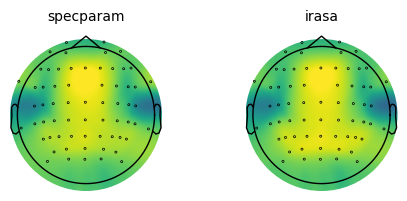

In [47]:
axes = make_axes(1, len(exp_measures), figsize=(5, 3), wspace=0.55)
for measure, ax in zip(exp_measures, axes):
    ax.set_title(measure, fontdict={'fontsize' : 10})
    plot_topomap(group_avg[measure], info, cmap=cm.viridis, contours=0, size=2, axes=ax, show=False)
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_topos' + EXT))

#### Time Series Measure Topographies

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:57: DeprecationWarning: Passing `np.nan` to mean no clipping in np.clip has always been unreliable, and is now deprecated. In future, this will always return nan, like it already does when min or max are arrays that contain nan. To skip a bound, pass either None or an np.inf of an appropriate sign.
  return bound(*args, **kwds)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:57: DeprecationWarning: Passing `np.nan` to mean no clipping in np.clip has always been unreliable, and is now deprecated. In future, this will always return nan, like it already does when min or max are arrays that contain nan. To skip a bound, pass either None or an np.inf of an appropriate sign.
  return bound(*args, **kwds)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:57: DeprecationWarning: Passing `np.nan` to mean no clipping in np.clip has 

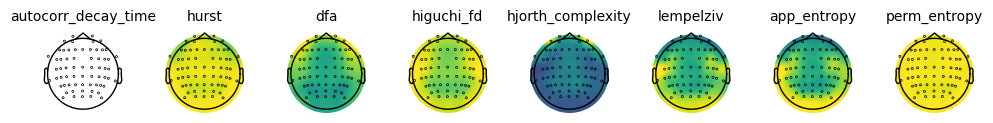

In [48]:
axes = make_axes(1, len(ts_measures), figsize=(12, 3), wspace=0.55)
for measure, ax in zip(ts_measures, axes):
    ax.set_title(measure, fontdict={'fontsize' : 10})
    plot_topomap(group_avg[measure], info, cmap=cm.viridis, contours=0, size=2, axes=ax, show=False)
if SAVE_FIG: plt.savefig(FIGPATH / ('ts_topos' + EXT))

### Spatial Correlations

In [49]:
group_avg_ts = deepcopy(group_avg)
[group_avg_ts.pop(meas) for meas in exp_measures];

In [50]:
group_corrs = compute_all_corrs(group_avg_ts)

In [51]:
group_corrs_mat = unpack_corrs(group_corrs)

In [64]:
mask = np.triu(group_corrs_mat)
labels = list(group_corrs.keys())
short_labels = ['AC Decay', 'Hurst', 'DFA', 'Higuchi', 'LZC', 'HJC', 'AppE', 'PermE']

In [65]:
group_corrs_mat = unpack_corrs(group_corrs)

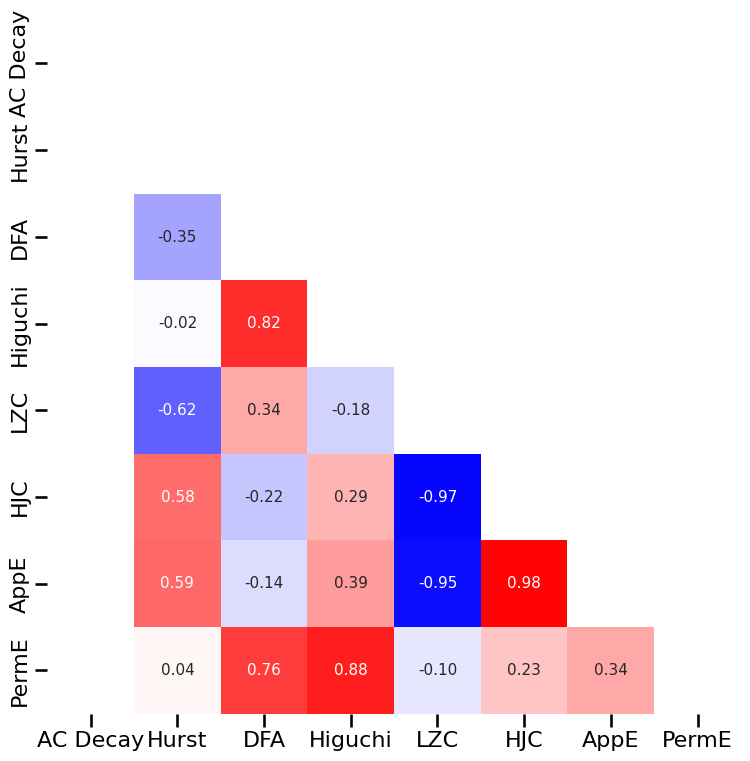

In [82]:
plot_corr_matrix(group_corrs_mat, xticklabels=short_labels, yticklabels=short_labels,
                 cbar=False, figsize=(8, 8),
                 save_fig=SAVE_FIG, file_name='ts_corr_mat' + EXT, file_path=FIGPATH)

In [69]:
group_exp_corrs = compute_corrs_to_feature(group_avg_ts, group_avg['specparam'])

In [70]:
exp_corr_mat = np.atleast_2d([group_exp_corrs[label][0] for label in group_exp_corrs]).T

In [71]:
#plot_corr_matrix(exp_corr_mat, cbar=False, xticklabels=[], yticklabels=[], square=True)

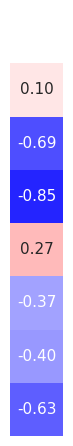

In [72]:
plot_corr_matrix(exp_corr_mat, xticks=[], yticks=[], cbar=False,
                 save_fig=SAVE_FIG, file_name='exp_corr_space' + EXT, file_path=FIGPATH)

## Alpha Power Topography

In [73]:
group_results_peaks = run_group_measures(group_data, peak_measures)

In [74]:
group_results_peaks['alpha_power'] = np.log10(group_results_peaks['alpha_power'])

In [75]:
group_avg_peaks = compute_avgs(group_results_peaks)

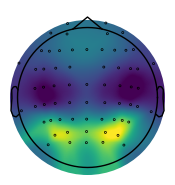

In [81]:
plot_topomap(group_avg_peaks['alpha_power'], info, cmap=cm.viridis,
             contours=0, size=2, vlim=(-11.5, -10.5), show=False)
if SAVE_FIG: plt.savefig(FIGPATH / ('alpha_topo' + EXT))

In [77]:
# Compute correlations between aperiodic measures and alpha power
group_alpha_corrs = compute_corrs_to_feature(group_avg_ts, group_avg_peaks['alpha_power'])

In [78]:
# Compute differences between correlations between aperiodic measures and alpha power
group_alpha_corr_diffs = compute_diffs_to_feature(group_avg_ts, group_avg_peaks['alpha_power'])

In [79]:
alpha_corr_mat = np.atleast_2d([group_alpha_corrs[label][0] for label in group_alpha_corrs]).T

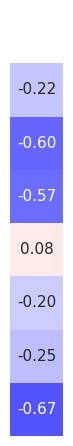

In [80]:
plot_corr_matrix(alpha_corr_mat, xticks=[], yticks=[], cbar=False,
                 save_fig=SAVE_FIG, file_name='alpha_corr_space' + EXT, file_path=FIGPATH)

## Conclusions

Conclusions of this empirical data analysis thus far:
- in this EEG data, the specparam & IRASA exponent estimates are highly comparable
- in this empirical data, aperiodic exponent is moderately correlated with the time domain methods

Note that this dataset is analyzed as a small / pilot, such that these interim conclusions are not considered decisive, and are best considered as initial results to be further explored and replicated in subsequent larger datasets.